## Pystac Data Catalog

The objective is to access LANDSAT for our AOIs and create datacubes for each region of interest that we read from the geojson file. 

In [59]:
import pystac_client
import geopandas as gpd
import rioxarray as rxr
import rasterio
import numpy as np
import xarray as xr
import planetary_computer
# import odc.stac
import matplotlib.pyplot as plty
import pandas as pd


from pystac.extensions.eo import EOExtension as eo


In [60]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


In [ ]:
# # List all available collections
# collections = catalog.get_all_collections()
# print("🌍 Available Collections:")
# for collection in collections:
#     print(f" - {collection.id}")

🌍 Available Collections:
 - daymet-annual-pr
 - daymet-daily-hi
 - 3dep-seamless
 - 3dep-lidar-dsm
 - fia
 - sentinel-1-rtc
 - gridmet
 - daymet-annual-na
 - daymet-monthly-na
 - daymet-annual-hi
 - daymet-monthly-hi
 - daymet-monthly-pr
 - gnatsgo-tables
 - hgb
 - cop-dem-glo-30
 - cop-dem-glo-90
 - terraclimate
 - nasa-nex-gddp-cmip6
 - gpm-imerg-hhr
 - gnatsgo-rasters
 - 3dep-lidar-hag
 - io-lulc-annual-v02
 - goes-cmi
 - conus404
 - 3dep-lidar-intensity
 - 3dep-lidar-pointsourceid
 - mtbs
 - noaa-c-cap
 - 3dep-lidar-copc
 - modis-64A1-061
 - alos-fnf-mosaic
 - 3dep-lidar-returns
 - mobi
 - landsat-c2-l2
 - era5-pds
 - chloris-biomass
 - kaza-hydroforecast
 - planet-nicfi-analytic
 - modis-17A2H-061
 - modis-11A2-061
 - daymet-daily-pr
 - 3dep-lidar-dtm-native
 - 3dep-lidar-classification
 - 3dep-lidar-dtm
 - gap
 - modis-17A2HGF-061
 - planet-nicfi-visual
 - gbif
 - modis-17A3HGF-061
 - modis-09A1-061
 - alos-dem
 - alos-palsar-mosaic
 - deltares-water-availability
 - modis-16A3GF-

In [ ]:
# # Choose a Landsat collection
# landsat_metadata = catalog.get_collection("landsat-c2-l2")

# # Print metadata
# print("\n🗂️ Landsat Metadata:")
# print(f"📌 Description: {landsat_metadata.description}")
# print(f"🗺️ Spatial Coverage: {landsat_metadata.extent.spatial.bboxes}")



🗂️ Landsat Metadata:
📌 Description: Landsat Collection 2 Level-2 [Science Products](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products), consisting of atmospherically corrected [surface reflectance](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance) and [surface temperature](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature) image data. Collection 2 Level-2 Science Products are available from August 22, 1982 to present.

This dataset represents the global archive of Level-2 data from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2) acquired by the [Thematic Mapper](https://landsat.gsfc.nasa.gov/thematic-mapper/) onboard Landsat 4 and 5, the [Enhanced Thematic Mapper](https://landsat.gsfc.nasa.gov/the-enhanced-thematic-mapper-plus-etm/) onboard Landsat 7, and the [Operatational Land Imager](https://landsat.gsfc.nasa.gov/satellites/landsat-8/spacec

In [63]:

landsat_collections = [
    "landsat-c2-l2", 
]
# Define date range (2000-2020)
date_range = "2000-01-01/2020-12-31"
bbox = [-17.819824, 12.105957, -11.315918, 16.700164]
search = catalog.search(
    collections=landsat_collections,
    bbox=bbox,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": 20},
           "platform": {"in": ["landsat-4", "landsat-5", "landsat-8", "landsat-9"]}  # Only low-cloud imagery
                },  # Only low-cloud images
)

# check the bands available
items = list(search.items())
item = items[0]
max_key_length = len(max(item.assets, key=len))
for key, asset in item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [64]:
items = search.item_collection()

In [65]:
len(items)

3008

In [ ]:
# df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
# df

,geometry,gsd,created,sci:doi,datetime,platform,proj:shape,description,instruments,eo:cloud_cover,...,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category,proj:code
0,"POLYGON ((-18.85371 15.49867, -17.16328 15.144...",30,2022-05-06T18:04:21.799112Z,10.5066/P9OGBGM6,2020-12-30T11:33:56.362492Z,landsat-8,"[7701, 7541]",Landsat Collection 2 Level-2,"[oli, tirs]",8.12,...,LC82060502020365LGN00,206,2,146.134603,L2SP,44.954731,0.02,02,T1,EPSG:32627
1,"POLYGON ((-16.9951 16.9427, -15.29337 16.58749...",30,2022-05-06T17:33:51.386912Z,10.5066/P9OGBGM6,2020-12-23T11:27:23.612124Z,landsat-8,"[7781, 7631]",Landsat Collection 2 Level-2,"[oli, tirs]",17.90,...,LC82050492020358LGN00,205,2,148.293915,L2SP,44.055810,25.67,02,T1,EPSG:32628
2,"POLYGON ((-16.67552 18.38633, -14.95952 18.030...",30,2022-05-06T17:33:47.984517Z,10.5066/P9OGBGM6,2020-12-23T11:26:59.708375Z,landsat-8,"[7781, 7631]",Landsat Collection 2 Level-2,"[oli, tirs]",0.21,...,LC82050482020358LGN00,205,2,149.244232,L2SP,42.933589,0.33,02,T1,EPSG:32628
3,"POLYGON ((-12.04179 18.38645, -10.32642 18.030...",30,2022-05-06T16:54:28.637527Z,10.5066/P9OGBGM6,2020-12-18T11:08:28.264926Z,landsat-8,"[7821, 7671]",Landsat Collection 2 Level-2,"[oli, tirs]",0.06,...,LC82020482020353LGN00,202,2,149.899233,L2SP,43.250756,0.06,02,T1,EPSG:32629
4,"POLYGON ((-16.40009 12.60974, -16.77387 10.874...",30,2022-06-02T09:15:14.242656Z,10.5066/P9OGBGM6,2020-12-16T11:22:25.812063Z,landsat-8,"[7761, 7601]",Landsat Collection 2 Level-2,"[oli, tirs]",0.03,...,LC82040522020351LGN00,204,2,146.025869,L2SP,47.874540,0.05,02,T1,EPSG:32628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,"POLYGON ((-15.54084 16.83526, -15.89215 15.237...",30,2022-05-06T17:21:21.471397Z,10.5066/P9IAXOVV,2006-10-23T11:15:07.315013Z,landsat-5,"[6961, 7841]",Landsat Collection 2 Level-2,[tm],0.00,...,LT52040492006296MPS00,204,2,139.951978,L2SP,54.951242,0.00,02,T1,EPSG:32628
3004,"POLYGON ((-15.21932 18.28445, -15.57363 16.686...",30,2022-05-06T17:21:20.666752Z,10.5066/P9IAXOVV,2006-10-23T11:14:43.341094Z,landsat-5,"[6961, 7831]",Landsat Collection 2 Level-2,[tm],0.00,...,LT52040482006296MPS00,204,2,141.535193,L2SP,53.966997,0.00,02,T1,EPSG:32628
3005,"POLYGON ((-18.94951 15.3799, -19.29825 13.7817...",30,2022-05-06T17:32:14.557557Z,10.5066/P9IAXOVV,2006-10-21T11:27:51.747075Z,landsat-5,"[6901, 7791]",Landsat Collection 2 Level-2,[tm],4.00,...,LT52060502006294MPS00,206,2,137.333706,L2SP,56.382259,0.00,02,T1,EPSG:32627
3006,"POLYGON ((-18.63155 16.83393, -18.98302 15.236...",30,2022-05-06T17:32:13.463587Z,10.5066/P9IAXOVV,2006-10-21T11:27:27.774056Z,landsat-5,"[7041, 7921]",Landsat Collection 2 Level-2,[tm],2.00,...,LT52060492006294MPS00,206,2,139.058718,L2SP,55.446832,0.00,02,T2,EPSG:32628


In [67]:
item = items[0]
item.assets.keys()

dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])

In [68]:
asset = item.assets["red"]
asset.extra_fields

{'eo:bands': [{'name': 'OLI_B4',
   'center_wavelength': 0.65,
   'full_width_half_max': 0.04,
   'common_name': 'red',
   'description': 'Visible red'}],
 'raster:bands': [{'scale': 2.75e-05,
   'nodata': 0,
   'offset': -0.2,
   'data_type': 'uint16',
   'spatial_resolution': 30}]}

In [69]:
footprint = gpd.read_file(r"D:\PHD\PLUS-CLIMB\Notebooks\grid_1.geojson")
footprint.total_bounds

array([-17.59397155,  14.16122794, -15.41343794,  16.724015  ])

In [ ]:
#dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])

# Desired band names you want to keep
desired_bands = {
    'qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal'
}

# Filter each item to retain only desired bands
filtered_items = []
for item in items:
    filtered_assets = {
        band: asset for band, asset in item.assets.items()
        if band in desired_bands
    }
    # Only keep the item if it has at least one matching band
    if filtered_assets:
        item.assets = filtered_assets
        filtered_items.append(item)

# filtered_items

[<Item id=LC08_L2SP_206050_20201230_02_T1>,
 <Item id=LC08_L2SP_205049_20201223_02_T1>,
 <Item id=LC08_L2SP_205048_20201223_02_T1>,
 <Item id=LC08_L2SP_202048_20201218_02_T1>,
 <Item id=LC08_L2SP_204052_20201216_02_T1>,
 <Item id=LC08_L2SP_204051_20201216_02_T1>,
 <Item id=LC08_L2SP_204050_20201216_02_T1>,
 <Item id=LC08_L2SP_204049_20201216_02_T1>,
 <Item id=LC08_L2SP_204048_20201216_02_T1>,
 <Item id=LC08_L2SP_201052_20201211_02_T1>,
 <Item id=LC08_L2SP_201051_20201211_02_T1>,
 <Item id=LC08_L2SP_201050_20201211_02_T1>,
 <Item id=LC08_L2SP_203052_20201209_02_T1>,
 <Item id=LC08_L2SP_203051_20201209_02_T1>,
 <Item id=LC08_L2SP_203050_20201209_02_T1>,
 <Item id=LC08_L2SP_203049_20201209_02_T1>,
 <Item id=LC08_L2SP_203048_20201209_02_T1>,
 <Item id=LC08_L2SP_205052_20201207_02_T1>,
 <Item id=LC08_L2SP_205051_20201207_02_T1>,
 <Item id=LC08_L2SP_205050_20201207_02_T1>,
 <Item id=LC08_L2SP_205049_20201207_02_T1>,
 <Item id=LC08_L2SP_205048_20201207_02_T1>,
 <Item id=LC08_L2SP_202052_20201

In [71]:
import stackstac # build an on-demand STAC data cube
from rasterio.enums import Resampling # perform resampling operations

cube = stackstac.stack(
    filtered_items,
    resolution=100,
    bounds_latlon=footprint.total_bounds,
    resampling=Resampling.bilinear,
    epsg = 32628
)
cube

<xarray.DataArray 'stackstac-ea7df97076173547671cbec09c34553f' (time: 963,
                                                                band: 16,
                                                                y: 2854, x: 2361)> Size: 831GB
dask.array<fetch_raster_window, shape=(963, 16, 2854, 2361), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                         (time) datetime64[ns] 8kB 2006-10-21T11:27:0...
    id                           (time) <U31 119kB 'LT05_L2SP_206048_20061021...
  * band                         (band) <U7 448B 'qa' 'red' ... 'coastal'
  * x                            (x) float64 19kB 2.199e+05 ... 4.559e+05
  * y                            (y) float64 23kB 1.851e+06 ... 1.566e+06
    sci:doi                      (time) <U16 62kB '10.5066/P9IAXOVV' ... '10....
    ...                           ...
    title                        (band) <U43 3kB 'Surface Temperature Quality...
    raster:bands                 (band) object 128B {'unit': 'kelvin', 'scale...
    common_name                  (band) object 128B None None ... 'coastal'
    center_wavelength            (band) object 128B None None None ... 10.9 0.44
    full_width_half_max          (band) object 128B None None None ... 0.59 0.02
    epsg                         int32 4B 32628
Attributes:
    spec:        RasterSpec(epsg=32628, bounds=(219900, 1565500, 456000, 1850...
    crs:         epsg:32628
    transform:   | 100.00, 0.00, 219900.00|\n| 0.00,-100.00, 1850900.00|\n| 0...
    resolution:  100

In [72]:

red = cube.sel(band="red")
nir = cube.sel(band="nir08")


ndvi = (nir - red) / (nir + red)
ndvi.name = "ndvi"


monthly_ndvi = ndvi.resample(time="MS").median("time", keep_attrs=True)


monthly_ndvi


<xarray.DataArray 'ndvi' (time: 171, y: 2854, x: 2361)> Size: 9GB
dask.array<where, shape=(171, 2854, 2361), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * x                          (x) float64 19kB 2.199e+05 2.2e+05 ... 4.559e+05
  * y                          (y) float64 23kB 1.851e+06 ... 1.566e+06
  * time                       (time) datetime64[ns] 1kB 2006-10-01 ... 2020-...
    landsat:correction         <U4 16B 'L2SP'
    landsat:collection_number  <U2 8B '02'
    description                object 8B None
    ...                         ...
    landsat:wrs_type           <U1 4B '2'
    raster:bands               object 8B {'scale': 2.75e-05, 'nodata': 0, 'of...
    common_name                object 8B None
    center_wavelength          object 8B None
    full_width_half_max        object 8B None
    epsg                       int32 4B 32628

In [76]:
monthly_ndvi[39].compute()

<xarray.DataArray 'ndvi' (y: 2854, x: 2361)> Size: 54MB
array([[-0.15672306, -0.14059872, -0.03983775, ...,  0.34165444,
         0.27051489,  0.2046236 ],
       [-0.09140401, -0.1090837 , -0.11394214, ...,  0.24948638,
         0.17833826,  0.17261654],
       [-0.05591033, -0.0939441 , -0.15372212, ...,  0.1988037 ,
         0.19048671,  0.21616982],
       ...,
       [-0.11467751, -0.1017752 , -0.11609246, ...,         nan,
                nan,         nan],
       [-0.09770575, -0.11314392, -0.11668364, ...,         nan,
                nan,         nan],
       [-0.12549302, -0.12803059, -0.11971421, ...,         nan,
                nan,         nan]])
Coordinates: (12/14)
  * x                          (x) float64 19kB 2.199e+05 2.2e+05 ... 4.559e+05
  * y                          (y) float64 23kB 1.851e+06 ... 1.566e+06
    time                       datetime64[ns] 8B 2010-01-01
    landsat:correction         <U4 16B 'L2SP'
    landsat:collection_number  <U2 8B '02'
    description                object 8B None
    ...                         ...
    landsat:wrs_type           <U1 4B '2'
    raster:bands               object 8B {'scale': 2.75e-05, 'nodata': 0, 'of...
    common_name                object 8B None
    center_wavelength          object 8B None
    full_width_half_max        object 8B None
    epsg                       int32 4B 32628

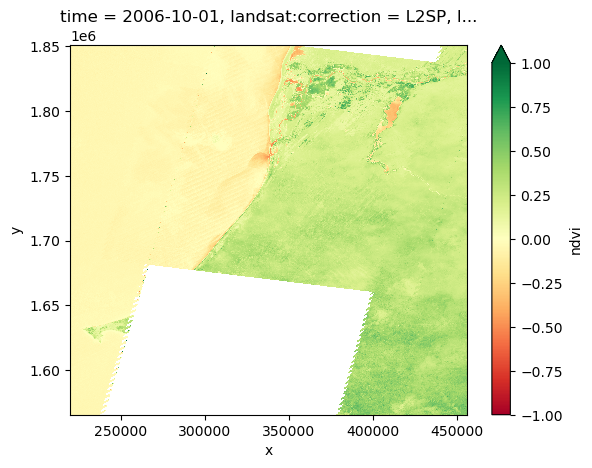

In [56]:
monthly_ndvi[0].plot(cmap="RdYlGn", vmin=-1, vmax=1)

In [57]:
#export to monthly_ndvi[0]
monthly_ndvi[0].rio.to_raster("ndvi_2006-01.tif", driver="GTiff", dtype="float32", compress="LZW")